Epoch 0/150, Train Loss: 1.0036, Val Loss: 1.6392
Epoch 10/150, Train Loss: 0.7149, Val Loss: 1.2938
Epoch 20/150, Train Loss: 0.5312, Val Loss: 0.8478
Epoch 30/150, Train Loss: 0.4447, Val Loss: 0.7025
Epoch 40/150, Train Loss: 0.4451, Val Loss: 0.6706
Epoch 50/150, Train Loss: 0.4173, Val Loss: 0.6691
Epoch 60/150, Train Loss: 0.3628, Val Loss: 0.6614
Epoch 70/150, Train Loss: 0.3867, Val Loss: 0.6766
Epoch 80/150, Train Loss: 0.3960, Val Loss: 0.6650
Epoch 90/150, Train Loss: 0.3795, Val Loss: 0.6573
Epoch 100/150, Train Loss: 0.3831, Val Loss: 0.6668
Epoch 110/150, Train Loss: 0.3824, Val Loss: 0.6655
Epoch 120/150, Train Loss: 0.3486, Val Loss: 0.6691
Epoch 130/150, Train Loss: 0.3886, Val Loss: 0.6758
Epoch 140/150, Train Loss: 0.3111, Val Loss: 0.6645


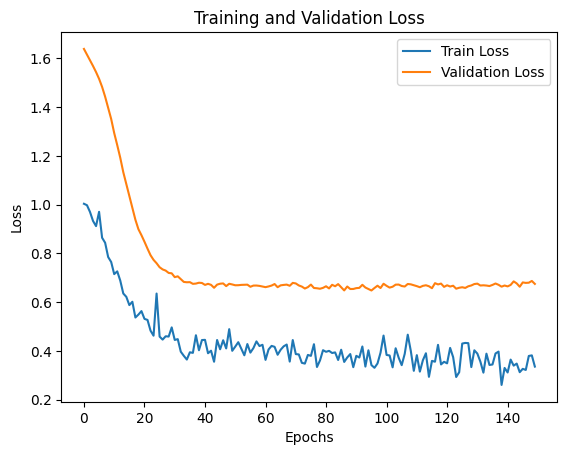

Test Loss: 0.6747
Test RMSE: 1438323.8287
Test R²: 0.5907
Model saved successfully.


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df = pd.read_csv("Housing.csv")

df = pd.get_dummies(df, columns=["mainroad", "guestroom", "basement", "hotwaterheating",
                                 "airconditioning", "prefarea", "furnishingstatus"], dtype=int)

df = df.fillna(df.mean())

X = df.drop(columns=["price"]).values
y = df["price"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        return x

model = HousePriceModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 150
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            val_predictions = model(inputs)
            val_loss = criterion(val_predictions, targets)
            total_val_loss += val_loss.item()

    val_losses.append(total_val_loss / len(test_loader))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.eval()
total_test_loss = 0
y_test_pred = []
y_test_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        test_predictions = model(inputs)
        test_loss = criterion(test_predictions, targets)
        total_test_loss += test_loss.item()
        y_test_pred.append(test_predictions.numpy())
        y_test_true.append(targets.numpy())

y_test_pred = scaler_y.inverse_transform(np.concatenate(y_test_pred))
y_test_true = scaler_y.inverse_transform(np.concatenate(y_test_true))

mse = mean_squared_error(y_test_true, y_test_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test_true, y_test_pred)

print(f"Test Loss: {total_test_loss / len(test_loader):.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")


torch.save(model.state_dict(), "house_price_model.pth")
print("Model saved successfully.")

In [2]:
from google.colab import files

uploaded = files.upload()


Saving Housing.csv to Housing.csv
